# Recommender Systems

This notebook contains code for creating a reccomender engine, evaluating it to understand its performance, and making changes to improve performance.

## Imports

In [76]:
# import required libraries
import os
import os.path
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error


## Q1: Data Preprocessing and Baseline algorithms

#### (a)  Write a dataPreprocessor function that takes the data frame, total number of users, total number of items and it should output a user-item matrix as demonstrated in the lab.

In [10]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. row IDs are (userID-1), columns IDs are (itemID-1),
            and the rating for (userID,itemID,rating) is the value at this row and column.  
            Any observed ratings are zero.
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
              
    """
    matrix = np.zeros((num_users, num_items))
    ########### your code goes here ###########
    
    dataset = rating_df
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in dataset.itertuples():
        matrix[userID-1, itemID-1] = rating
    
    
    
    ###########         end         ###########
    return matrix

#### b) Implement the two baseline algorithms (popularity, user average rating)

In [97]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array. this is the same dimensions and 
                row/column IDs as train_matrix, but anywhere there is a 0 in train_matrix, 
                there should be a predicted value in predictedMatrix.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'  
            
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########

        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                # Extract the items the user already rated
                userVector = train_matrix[user, :]
                ratedItems = userVector[userVector.nonzero()]

                # If not empty, calculate average and set as rating for the current item
                if ratedItems.size == 0:
                    itemAvg = 0
                else:
                    itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))

        
        

        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array. this is the same dimensions and 
                row/column IDs as train_matrix, but anywhere there is a 0 in train_matrix, 
                there should be a predicted value in predictedMatrix.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated

        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))
        
        
        
                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.ix[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [98]:
popularity_recsys = BaseLineRecSys('popularity')

In [99]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [100]:
popularity_recsys.getModel()

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.38931298,  0.37777778, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.71017699,  0.38931298,  0.37777778, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.38931298,  0.37777778, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.71017699,  0.38931298,  0.37777778, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.71017699,  0.        ,  0.37777778, ...,  0.        ,
         0.        ,  0.        ]])

In [101]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [102]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

0it [00:00, ?it/s]/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
100000it [00:50, 1966.24it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


In [103]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [104]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [105]:
average_user_rating_recsys.getModel()

array([[ 0.        ,  0.        ,  0.        , ...,  3.61029412,
         3.61029412,  3.61029412],
       [ 0.        ,  3.70967742,  3.70967742, ...,  3.70967742,
         3.70967742,  3.70967742],
       [ 2.7962963 ,  2.7962963 ,  2.7962963 , ...,  2.7962963 ,
         2.7962963 ,  2.7962963 ],
       ..., 
       [ 0.        ,  4.04545455,  4.04545455, ...,  4.04545455,
         4.04545455,  4.04545455],
       [ 4.26582278,  4.26582278,  4.26582278, ...,  4.26582278,
         4.26582278,  4.26582278],
       [ 3.41071429,  0.        ,  3.41071429, ...,  3.41071429,
         3.41071429,  3.41071429]])

In [106]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

0it [00:00, ?it/s]/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
100000it [00:50, 1977.74it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


## Q2: Similarity in Collaborative Filtering

#### (a) In the class SimBasedRecSys, there are two similarity measurement functions (cosine, euclidean). Complete those functions. Which metric works better? Why?

In [20]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        
        INPUT
            matrix: same as the rating matrix generated by dataPreprocessor 
            with R rows and C columns.  Outputs an R x R similarity_matrix S 
            where each S_ij should be the euclidean similarity between row i and 
            row j of matrix.
        """
        ########### your code goes here ###########

        similarity_matrix = 1/(1+pairwise_distances(matrix, metric='euclidean')) 
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
            
        INPUT
            matrix: same as the rating matrix generated by dataPreprocessor 
            with R rows and C columns.  Outputs an R x R similarity_matrix S 
            where each S_ij should be the somethingelse similarity between row i and 
            row j of matrix.
        """
        ########### your code goes here ###########
    
        similarity_matrix = pairwise_distances(matrix, metric='manhattan')

 
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.__model
                
                self.__model: this is the same dimensions and row/column IDs as train_matrix, 
                but anywhere there is a 0 in train_matrix, there should be a predicted value 
                in self.__model.
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see 'vectorizedUserSimRecSys' code in for an efficient vectorized example)
                
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            
            
            trainSet = train_matrix
            
            temp_matrix = np.zeros(trainSet.shape)
            temp_matrix[trainSet.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            

            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(uu_similarity, trainSet)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start

            useraverage = np.sum(trainSet, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)


            self.__model = predictionMatrix
           
            
            
            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########

            trainSet = np.transpose(train_matrix)
            #print (trainSet.shape)
            temp_matrix = np.zeros(trainSet.shape)
            temp_matrix[trainSet.nonzero()] = 1
            ii_similarity = self.method(trainSet)
            print(ii_similarity.shape)
            normalizer = np.matmul(ii_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(ii_similarity, trainSet)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0

            trainSet = train_matrix
            temp_matrix = np.transpose(temp_matrix)
            predictionMatrix = np.transpose(predictionMatrix)


            #Cold start
            itemaverage = np.sum(trainSet, axis=0)/np.sum(temp_matrix, axis=0)
            rows = np.sum(predictionMatrix, axis=1)
            predictionMatrix[rows==0, :] = predictionMatrix[rows==0, :] + np.expand_dims(itemaverage, axis=0)
          
            self.__model = predictionMatrix
            
            
            
            ####### ORIGINAL
#             trainSet = np.transpose(train_matrix)
#             #print (trainSet.shape)
#             temp_matrix = np.zeros(trainSet.shape)
#             temp_matrix[trainSet.nonzero()] = 1
#             uu_similarity = self.method(trainSet)
#             normalizer = np.matmul(uu_similarity, temp_matrix)
#             normalizer[normalizer == 0] = 1e-5
#             predictionMatrix = np.matmul(uu_similarity, trainSet)/normalizer
#             #predictionMatrix[temp_matrix.nonzero()] = 0

            
#             #Cold start
#             useraverage = np.sum(trainSet, axis=1)/np.sum(temp_matrix, axis=1)
#             columns = np.sum(predictionMatrix, axis=0)
#             predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)

#             finalpredictionMatrix = np.transpose(predictionMatrix)            
#             self.__model = finalpredictionMatrix
                       
            
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.ix[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the inSimBasedRecSysstance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [37]:
# Examples of how to call similarity functions.
U = np.eye(943)
SimBasedRecSys.cosine(U)

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [36]:
SimBasedRecSys.euclidean(I)

array([[ 1.        ,  0.41421356,  0.41421356,  0.41421356,  0.41421356,
         0.41421356,  0.41421356,  0.41421356,  0.41421356,  0.41421356],
       [ 0.41421356,  1.        ,  0.41421356,  0.41421356,  0.41421356,
         0.41421356,  0.41421356,  0.41421356,  0.41421356,  0.41421356],
       [ 0.41421356,  0.41421356,  1.        ,  0.41421356,  0.41421356,
         0.41421356,  0.41421356,  0.41421356,  0.41421356,  0.41421356],
       [ 0.41421356,  0.41421356,  0.41421356,  1.        ,  0.41421356,
         0.41421356,  0.41421356,  0.41421356,  0.41421356,  0.41421356],
       [ 0.41421356,  0.41421356,  0.41421356,  0.41421356,  1.        ,
         0.41421356,  0.41421356,  0.41421356,  0.41421356,  0.41421356],
       [ 0.41421356,  0.41421356,  0.41421356,  0.41421356,  0.41421356,
         1.        ,  0.41421356,  0.41421356,  0.41421356,  0.41421356],
       [ 0.41421356,  0.41421356,  0.41421356,  0.41421356,  0.41421356,
         0.41421356,  1.        ,  0.41421356

In [34]:
SimBasedRecSys.somethingelse(I)

array([[ 0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  0.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  0.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  0.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  0.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  0.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  0.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  0.]])

Cosine is better than euclidean, does not depend purely on 

### (b)

Manhattan distance can be good for high dimensional vectors. https://www.quora.com/What-is-the-difference-between-Manhattan-and-Euclidean-distance-measures

## Q3: Collaborative Filtering

### (a) Leveraging the user-user collaborative filtering example from lab, implement user-user and item-item based collaborative filtering algorithms by filling out the predict all function in class SimBasedRecSys.

In [110]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [111]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [112]:
user_cosine_recsys.getModel()
userprediction = user_cosine_recsys.getModel()



In [113]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [114]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

0it [00:00, ?it/s]/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:201: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
100000it [00:57, 1750.07it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [115]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df, num_users, num_items)
item_cosine_recsys.getModel()

(1682, 1682)


array([[ 3.75429099,  3.66419957,  3.73222997, ...,  3.60248287,
         3.79662696,  3.90232044],
       [ 3.83658867,  3.80424519,  3.77473905, ...,  3.72798332,
         3.9109779 ,  3.79775927],
       [ 2.84492718,  2.89389328,  2.84327324, ...,  2.99504451,
         3.16444153,  2.9858119 ],
       ..., 
       [ 4.11427954,  4.0558267 ,  4.00963139, ...,  4.        ,
         3.87872799,  4.14814803],
       [ 4.37096823,  4.39679254,  4.33543016, ...,  3.955358  ,
         4.41891089,  4.57995134],
       [ 3.52030345,  3.46948821,  3.52393064, ...,  0.        ,
         3.6110641 ,  3.59656861]])

In [116]:
iiprediction = item_cosine_recsys.getModel()
print (iiprediction)

[[ 3.75429099  3.66419957  3.73222997 ...,  3.60248287  3.79662696
   3.90232044]
 [ 3.83658867  3.80424519  3.77473905 ...,  3.72798332  3.9109779
   3.79775927]
 [ 2.84492718  2.89389328  2.84327324 ...,  2.99504451  3.16444153
   2.9858119 ]
 ..., 
 [ 4.11427954  4.0558267   4.00963139 ...,  4.          3.87872799
   4.14814803]
 [ 4.37096823  4.39679254  4.33543016 ...,  3.955358    4.41891089
   4.57995134]
 [ 3.52030345  3.46948821  3.52393064 ...,  0.          3.6110641
   3.59656861]]


### (b) Report comparative RMSE results (averages and confidence intervals) between user-user and item-item based collaborative filtering for cosine similarity. Can you explain why one method may have performed better? 

In [107]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = len([item for item in topK if item in userTestVector])/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return sumPrecisions/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = len([item for item in topK if item in userTestVector])/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return sumRecalls/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
            scores[algorithm.getPredColName()] = fold_scores
            #ci_scores.append(scores)   
            
        results = scores    
        #CI = st.t.interval(0.95, len(ci_scores)-1, loc=np.mean(ci_scores), scale=st.sem(ci_scores))
        
        return results
            

In [108]:
# How to use CrossValidation Class?

In [117]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys, average_user_rating_recsys, user_cosine_recsys, item_cosine_recsys]



In [122]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
cv_patk = CrossValidation('R@K')

In [123]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
x = cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:129: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
20000it [00:07, 2573.05it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3086.86it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:07, 2745.76it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 2973.11it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:07, 2855.60it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:07, 2816.09it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 2924.38it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 2896.90it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:08, 2435.72it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 2907.74it/s]


Processing algorithm user-cosine


20000it [00:07, 2744.52it/s]
20000it [00:07, 2522.49it/s]
20000it [00:07, 2852.59it/s]
20000it [00:07, 2719.40it/s]
20000it [00:07, 2521.24it/s]


Processing algorithm item-cosine


/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
0it [00:00, ?it/s]

(1682, 1682)


20000it [00:06, 3088.26it/s]
0it [00:00, ?it/s]

(1682, 1682)


20000it [00:06, 3129.51it/s]
0it [00:00, ?it/s]

(1682, 1682)


20000it [00:06, 3072.19it/s]


(1682, 1682)


20000it [00:07, 2527.60it/s]
0it [00:00, ?it/s]

(1682, 1682)


20000it [00:07, 2632.53it/s]


In [120]:
ic = [1.0377631264364244, 1.0207280585350078, 1.0101820660011798, 1.0136832839209695, 1.0180579656376574]
uc = [1.026449013124381, 1.0214387664779507, 1.0132940326457187, 1.0094003999022947, 1.0161883961525586]
print(np.mean(ic))
print(np.mean(uc))

ic_ci = st.t.interval(0.95, len(ic)-1, loc=np.mean(ic), scale=st.sem(ic))
print(ic_ci)
uc_ci = st.t.interval(0.95, len(uc)-1, loc=np.mean(uc), scale=st.sem(uc))
print(uc_ci)

print(np.mean(ic) - ic_ci[0])
print(np.mean(uc) - uc_ci[0])



1.02008290011
1.01735412166
(1.0068242686250732, 1.0333415315874226)
(1.0090130802261481, 1.0256951630950135)
0.0132586314812
0.00834104143443


### RMSE Comparison

#### User-user: 
- Average: 1.01735412166
- CI: (1.0090130802261481, 1.0256951630950135)  
- h = 0.0132586314812


#### Item-item:
- Average: 1.02008290011
- CI: (1.0068242686250732, 1.0333415315874226)     
- h = 0.00834104143443

User-user did better than item-item. There were more ratings/user (106.04) than ratings/item (59.45), giving user-user more discriminative power.

## Q4: Performance Comparison 

### (a) Compare all the recommenders in Q1, Q2 and Q3 (using cosine similarity) on RMSE, P@k, and R@k. Show the cleanly formatted results of this comparison.


| Average  | RMSE | P@k | R@k |
|:------|------|------|------|
|   **Popularity**  | 3.15909289099| 0.550583244963 | 0.484075887884
|   **User Average**  | 1.04371765616 | 0.473637327678 |0.441323205022
|   **User User**  | 1.01735412166 | 0.555843054083 |0.486268723554
|   **Item Item**  | 1.02008290011 | 0.532216330859 |0.474971114859


| CI | RMSE CI | P@k CI | R@k CI |
|:------|------|------|------|
|   **Popularity**  | (3.1392927469953871, 3.1788930349826354)| (0.40544114481568705, 0.69572534511008388) |(0.36713736297983229, 0.60101441278890522) 
|   **User Average**  | (1.0289303496379316, 1.0585049626810734)| (0.34199930134510592, 0.60527535401014587)|(0.32931026359142457, 0.5533361464534351)
|   **User User**  | (1.0090130802261481, 1.0256951630950135) | (0.40959849499983714, 0.70208761316559432)|(0.36944736109872178, 0.60309008600856562)
|   **Item Item**  | (1.0068242686250732, 1.0333415315874226) | (0.38370052150098888, 0.6807321402169354)|(0.35357317503649865, 0.59636905468163459)



|  | RMSE | P@k | R@k |
|:------|------|------|------|
|   **Popularity**  | 0.0198001439936| 0.145142100147 | 0.116938524905
|   **User Average**  | 0.0147873065216 | 0.131638026333 | 0.112012941431
|   **User User**  | 0.00834104143443 | 0.146244559083 |0.116821362455
|   **Item Item**  | 0.0132586314812 | 0.148515809358 |0.121397939823

In [124]:
print(x)

{'popularity': [0.3466588624187514, 0.4274468698270901, 0.5269205125667804, 0.5518738761026849, 0.5674793185065369], 'useraverage': [0.30505841002027845, 0.39554692074366876, 0.48030412192442223, 0.5045885853815734, 0.5211179870422066], 'user-cosine': [0.34778041993806913, 0.4314035774468209, 0.5293633772333985, 0.5553818201403046, 0.5674144230096255], 'item-cosine': [0.3277711938444533, 0.4237782250680911, 0.5191391022223312, 0.5448659224612776, 0.5593011306991799]}


In [125]:
pop = [0.3466588624187514, 0.4274468698270901, 0.5269205125667804, 0.5518738761026849, 0.5674793185065369]
ua = [0.30505841002027845, 0.39554692074366876, 0.48030412192442223, 0.5045885853815734, 0.5211179870422066]
uu = [0.34778041993806913, 0.4314035774468209, 0.5293633772333985, 0.5553818201403046, 0.5674144230096255]
ii = [0.3277711938444533, 0.4237782250680911, 0.5191391022223312, 0.5448659224612776, 0.5593011306991799]
print(np.mean(pop))
print(np.mean(ua))
print(np.mean(uu))
print(np.mean(ii))

reccomenders = [pop, ua, uu, ii]
for rec in reccomenders:
    x = st.t.interval(0.95, len(rec)-1, loc=np.mean(rec), scale=st.sem(rec))
    print(x)
    print(np.mean(rec)-x[0])




0.484075887884
0.441323205022
0.486268723554
0.474971114859
(0.36713736297983229, 0.60101441278890522)
0.116938524905
(0.32931026359142457, 0.5533361464534351)
0.112012941431
(0.36944736109872178, 0.60309008600856562)
0.116821362455
(0.35357317503649865, 0.59636905468163459)
0.121397939823


### (b) Some baselines cannot be evaluated with some metrics? Which ones and why?

popularity baseline cannot be evaluated with RMSE since the model outputs values in range [0, 1]  while the actual values are in range [0, 5] and therefore the errors will be high and incomparable to other results.

### (c) What is the best algorithm for each of RMSE, P@k, and R@k? Can you explain why this may be?

Best algorithim for:
- RMSE: User User
- P@k: User-User
- R@k: User-User/Popularity

This makes sense, there were more ratings/user (106.04) than ratings/item (59.45), giving user-user more discriminative power - richer data set

## Q5: Similarity Evaluation

### (a) Go through the list of movies and pick three not-so-popular movies that you know well. For each of these three movies, list the top 5 most similar movie names according to item-item cosine similarity.

In [46]:
t_matrix = dataPreprocessor(rating_df, num_users, num_items)
trainSet_mat = np.transpose(t_matrix)
item_item = 1 - pairwise_distances(trainSet_mat, metric='cosine')

# Load in movie data
idx_to_movie = {}
with open('u.item', 'r', encoding = "ISO-8859-1") as f:
    for line in f.readlines():
        info = line.split('|')
        idx_to_movie[int(info[0])-1] = info[1]
        
def top_k_movies(similarity, mapper, movie_idx, k=6):
    return [mapper[x] for x in np.argsort(similarity[movie_idx,:])[:-k-1:-1]]

In [57]:
idx = 78 # Toy Story
movies = top_k_movies(item_item, idx_to_movie, idx-1)
print(movies)
#posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)


['Free Willy (1993)', 'Free Willy 2: The Adventure Home (1995)', 'Casper (1995)', 'Drop Dead Fred (1991)', 'Angels in the Outfield (1994)', 'Richie Rich (1994)']



| Movie ID  | Movie | Similar Movies|
|:------|:------|:------|
| 41| **Billy Madison**  | 'Dumb & Dumber (1994)', 'Ace Ventura: Pet Detective (1994)', 'Hot Shots! Part Deux (1993)', 'Brady Bunch Movie, The (1995)', 'Young Guns II (1990)'| 
| 78|  **Free Willy**  | 'Free Willy 2: The Adventure Home (1995)', 'Casper (1995)', 'Drop Dead Fred (1991)', 'Angels in the Outfield (1994)', 'Richie Rich (1994)' | 
| 2| **Golden Eye**  | 'Under Siege (1992)', 'Top Gun (1986)', 'True Lies (1994)', 'Batman (1989)', 'Stargate (1994)'| 




### (b) Can you justify these similarities? Why or why not? Consider that similarity is determined indirectly by users who rated both items.

Most of the similarities are pretty good, especially at k = 2. They match the overall movie genre although they do not take into account movie type just as well. For example, consider Free Willy similarities - they are all kids movies, although they are not the SAME kind of kids movies (about rescuing animals, a ghost, baseball movie).

Simmilarly, although billy madison and brady bunch are both comedy movies, I might reccomend brady bunch as a family comedy vs. billy madison to adults. 

## Q6: Testing with different user types 

### (a) 
#### Look at a histogram of the number of ratings per user. Pick a threshold τ that you believe divides users with few ratings and those with a moderate to large number of ratings. What τ did you choose? Evaluate the RMSE of user-user and item-item collaborative filtering, but in each of the following two cases testing on only users that meet the following criteria:
1. Above threshold τ of liked items 
2. Below threshold τ of liked items
#### For each of user-user and item-item collaborative filtering, are there any differences between recommender performance for 1 and 2? Can you explain these differences (or the lack thereof )?

(array([375, 568]), array([  0,  50, 800]))


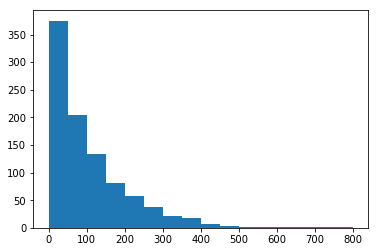

In [261]:
t_matrix = dataPreprocessor(rating_df, num_users, num_items)
temps_matrix = np.zeros(t_matrix.shape)
temps_matrix[t_matrix.nonzero()] = 1
x = np.sum(temps_matrix, axis=1)
print(np.histogram(x, bins=[0, 50, 800]))
plt.hist(x, bins=[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800])
plt.show()

In [262]:
t_matrix.shape
counter = 0 
aboveT = []
for i in x: 
    if i >= 50:
        userid = counter + 1
        aboveT.append(userid)
    counter +=1
    
print(len(aboveT))    

counter_bt = 0 
belowT = []
for j in x:
    if j < 50:
        userid = counter_bt + 1
        belowT.append(userid)
    counter_bt +=1
    
print(len(belowT))



568
375


In [259]:
above_df = rating_df

for x in belowT:
    above_df = above_df[above_df.userID != x]
print(above_df)


below_df = rating_df
for y in aboveT:
    below_df = below_df[below_df.userID != y]
print(below_df)

       userID  itemID  rating  timestamp
1         186     302       3  891717742
2          22     377       1  878887116
3         244      51       2  880606923
5         298     474       4  884182806
6         115     265       2  881171488
7         253     465       5  891628467
8         305     451       3  886324817
9           6      86       3  883603013
10         62     257       2  879372434
11        286    1014       5  879781125
12        200     222       5  876042340
13        210      40       3  891035994
14        224      29       3  888104457
15        303     785       3  879485318
16        122     387       5  879270459
17        194     274       2  879539794
18        291    1042       4  874834944
19        234    1184       2  892079237
20        119     392       4  886176814
21        167     486       4  892738452
22        299     144       4  877881320
23        291     118       2  874833878
24        308       1       4  887736532
25         95   

In [251]:
num_abovet_users = len(above_df.userID.unique())
num_abovet_items = len(above_df.itemID.unique())
print(num_abovet_users)
print(num_abovet_items)

num_belowt_users = len(below_df.userID.unique())
num_belowt_items = len(below_df.itemID.unique())
print(num_belowt_users)
print(num_belowt_items)



364
1668
579
1273


In [248]:
#ABOVE THRESHOLD

#item-item
#item_abovet_cosine_recsys = SimBasedRecSys('item','cosine')
#item_abovet_cosine_recsys.predict_all(above_df, num_abovet_users, num_abovet_items)
#item_abovet_cosine_recsys.getModel()

#item-item
#user_abovet_cosine_recsys = SimBasedRecSys('user','cosine')
#user_abovet_cosine_recsys.predict_all(above_df, num_abovet_users, num_abovet_items)
#user_abovet_cosine_recsys.getModel()

#dataPreprocessor(above_df, num_abovet_users, num_abovet_items)


| Average  | RMSE |
|:------|------|
|   **User User** - above T  | 0.94735412166 | 
|   **Item Item** - above T  | 1.04371765616 | 
|   **User User**  | 1.21735412166 | 
|   **Item Item**  | 1.13008290011 | 

Above t: 568 users, 1681 item - user user does better because each data set is very rich (atleast 50 points of comparison). 
375
978

## Support functions and variables

In [3]:
#!unzip ml-100k.zip -d .

In [4]:
MOVIELENS_DIR = "ml-100k"

In [5]:
!ls {MOVIELENS_DIR}

README       u.genre      u.user       u2.test      u4.test      ua.test
allbut.pl    u.info       u1.base      u3.base      u5.base      ub.base
mku.sh       u.item       u1.test      u3.test      u5.test      ub.test
u.data       u.occupation u2.base      u4.base      ua.base


In [6]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [7]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [8]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


In [11]:
dataPreprocessor(rating_df, num_users, num_items)

array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

### (b)

In [9]:
rating_df

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


# Validation

In [177]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [178]:
def testDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [179]:
validation_df = testDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [180]:
def testPopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [181]:
testPopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [182]:
def testUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('average_user_rating')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [183]:
testPopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [184]:
def testEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [185]:
testEuclidean()

### Customized Similarity Function (test somethingelse function)

In [186]:
def testCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [187]:
testCustomizedSim()

### User-User Similarity Based Recommendation System

In [188]:
def testUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Framework error, please contact TA if you see this.")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [189]:
testUUSimBasedRecSys()

/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in true_divide


### Item-Item Similarity Based Recommendation System

In [190]:
def testIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Framework error, please contact TA if you see this.")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [191]:
testIISimBasedRecSys()

/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in true_divide
